# Variational Autoencoder: PyTorch and MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.9.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 0
PyTorch does not have access to GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


In [5]:
# Hyper-parameters-
num_epochs = 50
batch_size = 32
learning_rate = 0.001

### MNIST data pre-processing:

In [6]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [7]:
path_to_data = "C:\\Users\\Arjun\\Desktop\\VAE_resources\\"
# path_to_data = "C:\\Users\\arjun\Downloads\\"

In [8]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        # root = './data', train = True,
        root = path_to_data + "data", train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        # root = './data', train = False,
        root = path_to_data + "data", train = False,
        transform = transforms_apply
        )

C:\Users\Arjun\anaconda3\envs\pytorch-cpu\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [10]:
print(f"Sizes of train_dataset: {len(train_dataset)} and test_dataet: {len(test_dataset)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 1875 and test_loader: 313


In [11]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 1875 & len(test_loader) = 313


In [12]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(1875.0, 312.5)

In [13]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([32, 1, 28, 28]) & labels.shape: torch.Size([32])


In [14]:
# Reshape input so that it can be fed into LeNet-300-100 architecture model-
images.reshape(-1, 28 * 28 * 1).shape

torch.Size([32, 784])

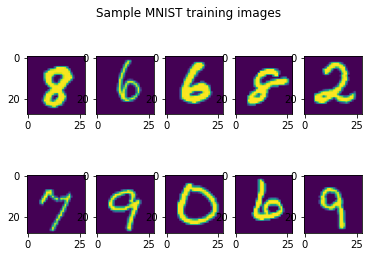

In [15]:
# Visualize 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0])    # 0 to access first channel
    # plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

### Define _Variational Autoencoder_ architecture:

In [16]:
class LeNet_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Encoder, self).__init__()
        
        self.latent_space = latent_space
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6,
            kernel_size = 3, stride = 2,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv3 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv4 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.dense = nn.Linear(
            in_features = 64, out_features = 30,
            bias = True
        )
        self.dense2 = nn.Linear(
            in_features = 30, out_features = 10,
            bias = True
        )
        self.encoder_output = nn.Linear(
            in_features = 10, out_features = self.latent_space,
            bias = True
        )
        
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        # print(f"before flatten, x.shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        x = F.leaky_relu(self.dense(x))
        x = F.leaky_relu(self.dense2(x))
        x = F.leaky_relu(self.encoder_output(x))
        return x
        


In [17]:
class LeNet_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Decoder, self).__init__()
        
        self.latent_space = latent_space
        self.dense_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 10,
            bias = True
        )
        self.dense_layer2 = nn.Linear(
            in_features = 10, out_features = 30,
            bias = True
        )
        self.dense_layer3 = nn.Linear(
            in_features = 30, out_features = 64,
            bias = True
        )
        
        self.conv_tran_layer1 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer2 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer3 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 6,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.op_conv_tran_layer = nn.ConvTranspose2d(
            in_channels = 6, out_channels = 1,
            kernel_size = 2, stride = 2,
            padding = 0
        )

        
        
    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        x = F.leaky_relu(self.dense_layer3(x))
        x = x.view(-1, 16, 2, 2)
        x = F.leaky_relu(self.conv_tran_layer1(x))
        x = F.leaky_relu(self.conv_tran_layer2(x))
        x = F.leaky_relu(self.conv_tran_layer3(x))
        x = F.leaky_relu(self.op_conv_tran_layer(x))
        return x
 

In [18]:
# encoder = LeNet_Encoder(latent_space = 3)

In [ ]:
# encoded_images = encoder(images)

In [ ]:
# encoded_images.shape, images.shape

In [19]:
# decoder = LeNet_Decoder(latent_space = 3)

In [21]:
# decoded_images = decoder(encoded_images)

In [20]:
# decoded_images.shape, images.shape

In [ ]:
# del encoded_images, decoded_images, encoder, decoder

In [18]:
class VAE_Conv(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Conv, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = LeNet_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'hidden2mu' & 'hidden2log' to convert the bottleneck into the μ and σ vectors-
        self.hidden2mu = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        self.hidden2log_var = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        
        # Decoder-
        self.decoder = LeNet_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        sample = mu + (std * eps)
        
        return sample
    
    
    def forward(self, x):
        # Encode input data-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # print(f"encoder's output x.shape: {x.shape}")
        
        mu = self.hidden2mu(x)
        log_var = self.hidden2log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        '''
        
        # Decode latent vector-
        recon_data = torch.sigmoid(self.decoder(z))
        # recon_data = torch.tanh(self.decoder(z))
        # x = self.decoder(z)
        # recon_data = torch.sigmoid(x) # or, tanh
        
        return recon_data, mu, log_var
        

In [19]:
# Initialize a VAE objetc-
model = VAE_Conv(latent_space = 3).to(device)

In [20]:
print(model)

VAE_Conv(
  (encoder): LeNet_Encoder(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (dense): Linear(in_features=64, out_features=30, bias=True)
    (dense2): Linear(in_features=30, out_features=10, bias=True)
    (encoder_output): Linear(in_features=10, out_features=3, bias=True)
  )
  (hidden2mu): Linear(in_features=3, out_features=3, bias=True)
  (hidden2log_var): Linear(in_features=3, out_features=3, bias=True)
  (decoder): LeNet_Decoder(
    (dense_layer1): Linear(in_features=3, out_features=10, bias=True)
    (dense_layer2): Linear(in_features=10, out_features=30, bias=True)
    (dense_layer3): Linear(in_features=30, out_features=64, bias=True)
    (conv_tran_layer1): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv_tran_layer2): ConvTranspos

In [21]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([6, 1, 3, 3]) has 54 parameters
layer.shape = torch.Size([6]) has 6 parameters
layer.shape = torch.Size([16, 6, 5, 5]) has 2400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([30, 64]) has 1920 parameters
layer.shape = torch.Size([30]) has 30 parameters
layer.shape = torch.Size([10, 30]) has 300 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([3, 10]) has 30 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([10, 3]) has 30 parameters
layer.shape = t

In [22]:
print(f"Total number of parameters in VAE Dense model = {tot_params}")

Total number of parameters in VAE Dense model = 35242


### Initial _variance_ - Sanity check:

_Before_ training the VAE neural network model, there should be some initial variance.

In [23]:
for x in model.hidden2mu.parameters():
    print(x.shape, x.nelement())

torch.Size([3, 3]) 9
torch.Size([3]) 3


In [24]:
log_var_wts = model.hidden2log_var.weight
mu_wts = model.hidden2mu.weight

In [25]:
mu_wts = mu_wts.detach().cpu().numpy()
log_var_wts = log_var_wts.detach().cpu().numpy()

In [26]:
mu_wts.shape, log_var_wts.shape

((3, 3), (3, 3))

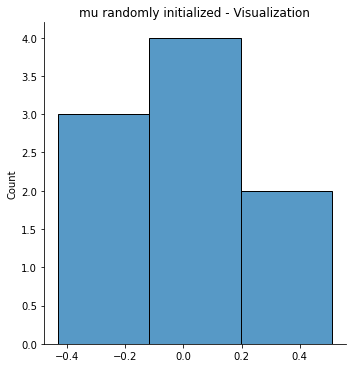

In [27]:
sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu randomly initialized - Visualization")
plt.show()

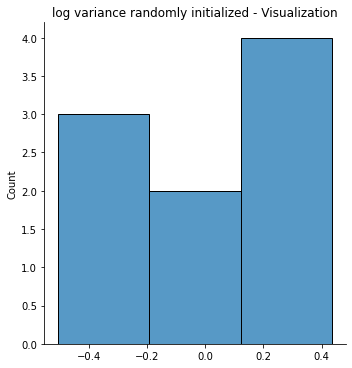

In [28]:
sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance randomly initialized - Visualization")
plt.show()

In [29]:
del mu_wts, log_var_wts

In [30]:
images = images.to(device)

In [31]:
images.shape

torch.Size([32, 1, 28, 28])

In [32]:
images.min(), images.max()

(tensor(-0.4242), tensor(2.8215))

In [33]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [34]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 3]), torch.Size([32, 3]))

In [35]:
recon_images.min().detach().cpu().numpy(), recon_images.max().detach().cpu().numpy()

# tanh activation function-
# (array(-0.05745536, dtype=float32), array(0.23623492, dtype=float32))

# sigmoid activation function-
# (array(0.43894547, dtype=float32), array(0.5463941, dtype=float32))

(array(0.49903697, dtype=float32), array(0.49929765, dtype=float32))

In [36]:
del recon_images, mu, log_var

In [37]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [38]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [39]:
# Reconstruction loss-
# criterion = nn.BCELoss(reduction = 'sum')

# Note: reduction='sum' is used for the BCELoss(). If you read the PyTorch
# documentations, then this is specifically for the case of autoencoders only.

# Also, MSE loss could also be used-
criterion = nn.MSELoss(reduction = 'sum')

In [40]:
def total_loss(reconstruction_loss, mu, log_var, alpha = 1):
    '''
    Function to add reconstruction loss and KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. recontruction loss - BCE or MSE loss
    2. mu: mean from the latent vector
    3. logvar: log variance from the latent vector
    4. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss.
    '''
    
    # reconstruction_loss = F.binary_cross_entropy_with_logits(input, target)
    
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # final_loss = reconstruction_loss + KLD
    final_loss = (reconstruction_loss * alpha) + KLD
    
    return final_loss


In [41]:
def train_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    running_loss = 0.0
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(train_dataset) / dataloader.batch_size)
        ):
      
        # Ignore labels-
        data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        reconstruction, mu, logvar = model(data)
        
        # Compute reconstruction loss-
        recon_loss = criterion(reconstruction, data)
        
        # Compute final loss-
        loss = total_loss(recon_loss, mu, logvar, alpha)
        
        # Update loss-
        running_loss += loss.item()
        
        # Compute gradients wrt loss-
        loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
        
    train_loss = running_loss / len(dataloader.dataset)
    
    return train_loss, mu, logvar


In [42]:
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(test_dataset) / dataloader.batch_size)):
          
            # Ignore labels-
            data, _ = data

            # Push data points to 'device'-
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            reconstruction, mu, logvar = model(data)
            
            # Compute reconstruction loss-
            recon_loss = criterion(reconstruction, data)
            
            # Compute total loss-
            loss = total_loss(recon_loss, mu, logvar, alpha)
            
            # Update loss-
            running_loss += loss.item()
            
    val_loss = running_loss / len(dataloader.dataset)
    
    return val_loss, mu, logvar


In [ ]:
# alpha = 1

In [ ]:
# Sanity check-
'''
train_epoch_loss, mu_train, logvar_train = train_one_epoch(
    model = model, dataloader = train_loader,
    alpha = alpha
    )
'''

In [ ]:
# Sanity check-
'''
val_epoch_loss, mu_val, logvar_val = validate_one_epoch(
    model = model, dataloader = test_loader,
    alpha = alpha
    )
'''

In [ ]:
# print(f"train loss = {train_loss:.4f} & test loss = {test_loss:.4f}")

In [43]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1

In [44]:
# Python dict to contain training metrics-
train_history = {}

In [46]:
num_epochs = 35
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 35 epochs


In [47]:
for epoch in range(1, num_epochs + 1):
    # Train model for 1 epoch-
    train_epoch_loss, mu_train, logvar_train = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha
    )
    
    # Get validation metrics-
    val_epoch_loss, mu_val, logvar_val = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha
    )
    
    # Retrieve model performance metrics-
    logvar_train = logvar_train.mean().detach().cpu().numpy()
    logvar_val = logvar_val.mean().detach().cpu().numpy()
    mu_train = mu_train.mean().detach().cpu().numpy()
    mu_val = mu_val.mean().detach().cpu().numpy()

    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_epoch_loss,
        'val_loss': val_epoch_loss,
        'train_logvar': logvar_train,
        'val_logvar': logvar_val,
        'train_mu': mu_train,
        'val_mu': mu_val
    }

    print(f"Epoch = {epoch}; train loss = {train_epoch_loss:.4f},"
    f"test loss = {val_epoch_loss:.4f}, train_logvar = {logvar_train:.6f}"
    f", train_mu = {mu_train:.6f}, val_logvar = {logvar_val:.6f} &"
    f" val_mu = {mu_val:.6f}")
    

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:59<00:00, 31.75it/s]
313it [00:04, 66.24it/s]                                                                                               


Epoch = 1; train loss = 660.7679,test loss = 618.4813, train_logvar = -1.165159, train_mu = 0.319179, val_logvar = -1.379400 & val_mu = 0.501818


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:53<00:00, 35.22it/s]
313it [00:03, 79.92it/s]                                                                                               


Epoch = 2; train loss = 607.4080,test loss = 606.0316, train_logvar = -1.940795, train_mu = 0.410325, val_logvar = -1.698166 & val_mu = 0.311680


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:57<00:00, 32.36it/s]
313it [00:03, 80.42it/s]                                                                                               


Epoch = 3; train loss = 598.3028,test loss = 596.4072, train_logvar = -1.636740, train_mu = 0.095797, val_logvar = -1.760023 & val_mu = 0.113907


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:58<00:00, 32.06it/s]
313it [00:04, 70.41it/s]                                                                                               


Epoch = 4; train loss = 592.3627,test loss = 592.1907, train_logvar = -2.205101, train_mu = 0.167120, val_logvar = -1.717926 & val_mu = -0.092422


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:57<00:00, 32.64it/s]
313it [00:03, 84.09it/s]                                                                                               


Epoch = 5; train loss = 587.2443,test loss = 586.4128, train_logvar = -2.059928, train_mu = 0.019957, val_logvar = -2.031322 & val_mu = -0.026992


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:57<00:00, 32.79it/s]
313it [00:04, 70.58it/s]                                                                                               


Epoch = 6; train loss = 582.8628,test loss = 581.1560, train_logvar = -1.844041, train_mu = -0.070277, val_logvar = -1.922169 & val_mu = 0.001796


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:55<00:00, 33.92it/s]
313it [00:03, 80.99it/s]                                                                                               


Epoch = 7; train loss = 578.6301,test loss = 577.8427, train_logvar = -1.900491, train_mu = 0.151157, val_logvar = -1.971646 & val_mu = -0.026739


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:56<00:00, 33.20it/s]
313it [00:04, 75.52it/s]                                                                                               


Epoch = 8; train loss = 575.4033,test loss = 582.9147, train_logvar = -1.825868, train_mu = -0.090097, val_logvar = -1.713750 & val_mu = -0.201293


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:03<00:00, 29.75it/s]
313it [00:03, 79.20it/s]                                                                                               


Epoch = 9; train loss = 573.3882,test loss = 572.4674, train_logvar = -2.090968, train_mu = -0.090733, val_logvar = -1.954915 & val_mu = -0.005753


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.08it/s]
313it [00:05, 59.87it/s]                                                                                               


Epoch = 10; train loss = 571.1476,test loss = 573.4838, train_logvar = -2.171991, train_mu = 0.023944, val_logvar = -2.050232 & val_mu = -0.033979


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:11<00:00, 26.21it/s]
313it [00:06, 51.55it/s]                                                                                               


Epoch = 11; train loss = 570.7696,test loss = 571.7010, train_logvar = -2.027296, train_mu = 0.053505, val_logvar = -2.106663 & val_mu = -0.028782


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:18<00:00, 23.78it/s]
313it [00:05, 57.73it/s]                                                                                               


Epoch = 12; train loss = 570.0434,test loss = 567.4978, train_logvar = -2.572828, train_mu = -0.183787, val_logvar = -2.379841 & val_mu = -0.116750


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:19<00:00, 23.71it/s]
313it [00:05, 58.71it/s]                                                                                               


Epoch = 13; train loss = 563.2827,test loss = 561.9053, train_logvar = -2.826833, train_mu = -0.014319, val_logvar = -3.085158 & val_mu = -0.173215


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:17<00:00, 24.19it/s]
313it [00:05, 61.55it/s]                                                                                               


Epoch = 14; train loss = 555.9238,test loss = 554.5186, train_logvar = -3.376940, train_mu = -0.047415, val_logvar = -3.658280 & val_mu = -0.236907


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:12<00:00, 25.74it/s]
313it [00:04, 64.51it/s]                                                                                               


Epoch = 15; train loss = 549.3686,test loss = 550.5296, train_logvar = -4.225997, train_mu = -0.357078, val_logvar = -4.052582 & val_mu = -0.225622


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:14<00:00, 25.09it/s]
313it [00:05, 57.69it/s]                                                                                               


Epoch = 16; train loss = 546.2109,test loss = 553.1069, train_logvar = -3.499786, train_mu = 0.416446, val_logvar = -3.825056 & val_mu = 0.275597


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:02<00:00, 29.95it/s]
313it [00:05, 55.40it/s]                                                                                               


Epoch = 17; train loss = 542.8625,test loss = 541.9633, train_logvar = -4.069236, train_mu = -0.046092, val_logvar = -4.066569 & val_mu = -0.200541


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 26.87it/s]
313it [00:04, 63.81it/s]                                                                                               


Epoch = 18; train loss = 539.7554,test loss = 541.6745, train_logvar = -3.984227, train_mu = -0.090019, val_logvar = -4.073028 & val_mu = -0.158399


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.50it/s]
313it [00:04, 69.24it/s]                                                                                               


Epoch = 19; train loss = 537.8958,test loss = 538.1284, train_logvar = -3.964993, train_mu = 0.271109, val_logvar = -4.176218 & val_mu = -0.157570


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.42it/s]
313it [00:04, 65.26it/s]                                                                                               


Epoch = 20; train loss = 535.0789,test loss = 536.5094, train_logvar = -4.083702, train_mu = -0.021789, val_logvar = -3.954385 & val_mu = 0.184652


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 27.08it/s]
313it [00:04, 70.23it/s]                                                                                               


Epoch = 21; train loss = 531.9915,test loss = 532.6983, train_logvar = -3.752239, train_mu = 0.014529, val_logvar = -3.931437 & val_mu = -0.092901


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.38it/s]
313it [00:04, 69.19it/s]                                                                                               


Epoch = 22; train loss = 531.1722,test loss = 533.3373, train_logvar = -3.724414, train_mu = 0.011038, val_logvar = -3.665711 & val_mu = 0.145245


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.67it/s]
313it [00:04, 68.19it/s]                                                                                               


Epoch = 23; train loss = 531.5554,test loss = 534.9358, train_logvar = -3.824136, train_mu = -0.096614, val_logvar = -3.788711 & val_mu = -0.240047


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.81it/s]
313it [00:05, 59.82it/s]                                                                                               


Epoch = 24; train loss = 528.4769,test loss = 532.3062, train_logvar = -3.829058, train_mu = -0.088092, val_logvar = -3.668916 & val_mu = 0.017778


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.54it/s]
313it [00:04, 65.32it/s]                                                                                               


Epoch = 25; train loss = 527.0878,test loss = 534.2342, train_logvar = -3.852567, train_mu = -0.209619, val_logvar = -3.943692 & val_mu = -0.494989


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:11<00:00, 26.33it/s]
313it [00:04, 74.07it/s]                                                                                               


Epoch = 26; train loss = 525.9526,test loss = 532.2706, train_logvar = -3.726838, train_mu = -0.048343, val_logvar = -3.756273 & val_mu = -0.127374


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:03<00:00, 29.60it/s]
313it [00:04, 71.56it/s]                                                                                               


Epoch = 27; train loss = 524.6949,test loss = 528.4679, train_logvar = -3.710399, train_mu = 0.029749, val_logvar = -3.727010 & val_mu = -0.065521


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:21<00:00, 22.89it/s]
313it [00:07, 43.85it/s]                                                                                               


Epoch = 28; train loss = 524.1386,test loss = 528.4313, train_logvar = -3.751532, train_mu = 0.099255, val_logvar = -3.743058 & val_mu = 0.058490


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:15<00:00, 24.79it/s]
313it [00:05, 62.49it/s]                                                                                               


Epoch = 29; train loss = 524.1128,test loss = 527.2782, train_logvar = -3.762284, train_mu = 0.135846, val_logvar = -3.818596 & val_mu = -0.007406


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:14<00:00, 25.24it/s]
313it [00:04, 67.56it/s]                                                                                               


Epoch = 30; train loss = 521.9107,test loss = 526.9128, train_logvar = -3.744208, train_mu = 0.025404, val_logvar = -3.829591 & val_mu = -0.381847


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:13<00:00, 25.67it/s]
313it [00:05, 58.14it/s]                                                                                               


Epoch = 31; train loss = 521.7599,test loss = 525.0091, train_logvar = -3.773144, train_mu = -0.242269, val_logvar = -3.782478 & val_mu = -0.142112


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.76it/s]
313it [00:05, 52.17it/s]                                                                                               


Epoch = 32; train loss = 523.2295,test loss = 525.4302, train_logvar = -3.875360, train_mu = -0.093042, val_logvar = -3.839638 & val_mu = -0.072871


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:26<00:00, 21.58it/s]
313it [00:04, 64.93it/s]                                                                                               


Epoch = 33; train loss = 520.4624,test loss = 522.8353, train_logvar = -3.915596, train_mu = -0.177927, val_logvar = -3.863285 & val_mu = -0.069108


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:13<00:00, 25.44it/s]
313it [00:05, 59.79it/s]                                                                                               


Epoch = 34; train loss = 518.3169,test loss = 520.2363, train_logvar = -3.745439, train_mu = 0.151757, val_logvar = -3.871496 & val_mu = -0.083134


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.07it/s]
313it [00:04, 67.88it/s]                                                                                               

Epoch = 35; train loss = 517.8927,test loss = 520.8359, train_logvar = -3.902562, train_mu = -0.241749, val_logvar = -3.911637 & val_mu = -0.153985


In [48]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_LeNet5_MNIST_Trained_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 5).to(device)
# loaded_model.load_state_dict(torch.load('VAE_LeNet5_MNIST_Trained_Weights.pth', map_location = torch.device('cpu')))

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [49]:

import pickle

# Save training history as pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

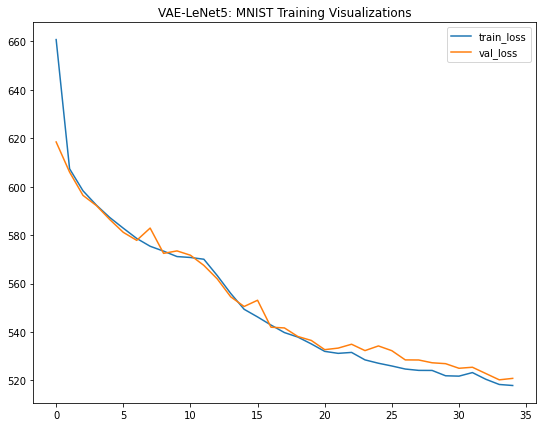

In [51]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_loss'] for x in train_history.keys()], label = 'train_loss')
plt.plot([train_history[x]['val_loss'] for x in train_history.keys()], label = 'val_loss')
plt.legend(loc = 'best')
plt.title("VAE-LeNet5: MNIST Training Visualizations")
plt.show()

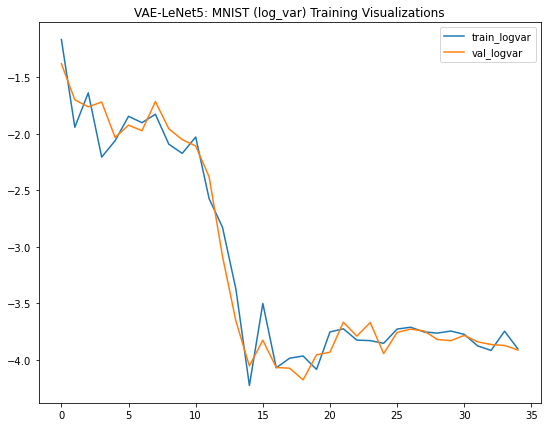

In [52]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_logvar'] for x in train_history.keys()], label = 'train_logvar')
plt.plot([train_history[x]['val_logvar'] for x in train_history.keys()], label = 'val_logvar')
plt.legend(loc = 'best')
plt.title("VAE-LeNet5: MNIST (log_var) Training Visualizations")
plt.show()

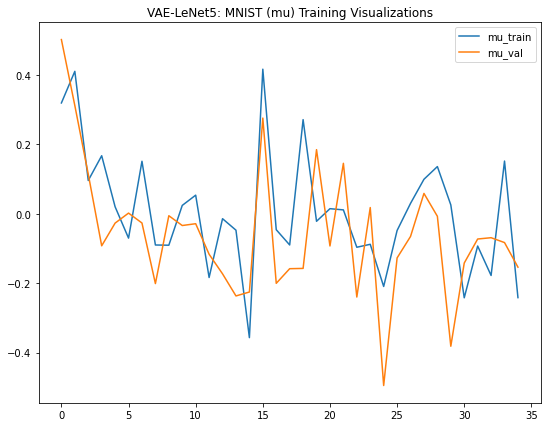

In [53]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_mu'] for x in train_history.keys()], label = 'mu_train')
plt.plot([train_history[x]['val_mu'] for x in train_history.keys()], label = 'mu_val')
plt.legend(loc = 'best')
plt.title("VAE-LeNet5: MNIST (mu) Training Visualizations")
plt.show()

### Reconstruct/Generate images using _trained_ VAE model:

In [54]:
images = images.to(device)

In [57]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [58]:
recon_images = recon_images.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()
log_var = log_var.cpu().detach().numpy()

In [59]:
recon_images.shape, mu.shape, log_var.shape

((32, 1, 28, 28), (32, 3), (32, 3))

In [40]:
# Unnormalize images-
# recon_images = recon_images / 2 + 0.5
# recon_images = np.transpose(recon_images, (0, 2, 3, 1))

In [60]:
recon_images.shape

(32, 1, 28, 28)

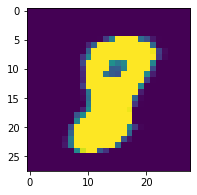

In [63]:
plt.figure(figsize = (5, 3))
plt.imshow(recon_images[0][0])
plt.show()


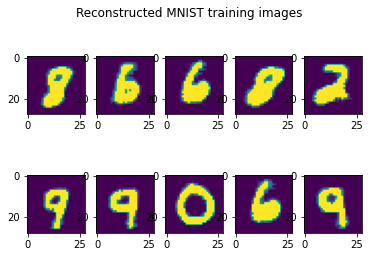

In [65]:
# Visualize 10 images from reconstructions-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(recon_images[i][0])
    
plt.suptitle("Reconstructed MNIST training images")
plt.show()


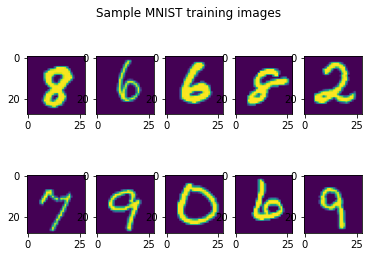

In [67]:
# Print 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0].cpu())
    
plt.suptitle("Sample MNIST training images")
plt.show()

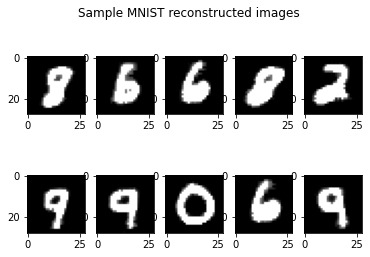

In [68]:
# Print 10 images from reconstructions-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST reconstructed images")
plt.show()

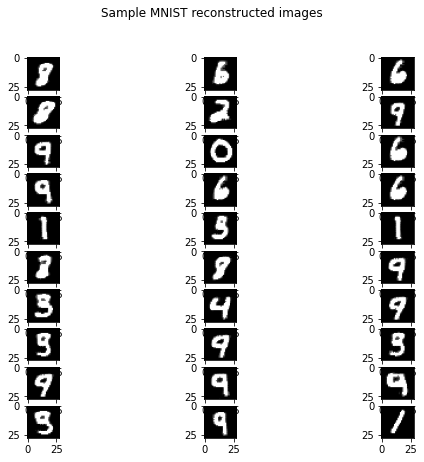

In [71]:
# Print 30 images from reconstructions-
plt.figure(figsize = (9, 7))

for i in range(30):
    plt.subplot(10, 3, i + 1)    # 10 rows & 3 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST reconstructed images")
plt.show()

In [ ]:
'''
# Iterating over train loader-
for img, label in train_loader:
    print(img.shape, label.shape)
'''

In [ ]:
# Get a batch of training data & it's corresponding labels-
images, labels = next(iter(train_loader))
images = images.to(device)

In [ ]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [ ]:
# FOR CUDA/GPU-
recon_images = recon_images.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
log_var = log_var.detach().cpu().numpy()

In [ ]:
recon_images.shape, mu.shape, log_var.shape

In [ ]:
!pip install umap-learn

In [ ]:
import umap
import umap.umap_ as umap

In [ ]:
reducer = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)

In [ ]:
embedding_mu = reducer.fit_transform(mu)
embedding_mu.shape

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(64, 3)

In [ ]:
reducer_logvar = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)

In [ ]:
embedding_logvar = reducer.fit_transform(log_var)
embedding_logvar.shape

(64, 3)

In [ ]:
import plotly
import plotly.express as px

In [ ]:
# Visualize latent space for 'mean'-
fig = px.scatter_3d(
    x = embedding_mu[:, 0], y = embedding_mu[:, 1],
    z = embedding_mu[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
# Visualize latent space for 'log variance'-
fig = px.scatter_3d(
    x = embedding_logvar[:, 0], y = embedding_logvar[:, 1],
    z = embedding_logvar[:, 2],
    # color = y_train
    )
fig.show()